*** 
# HCI Week 7 - Angular Differential Imaging
*Matthew Kenworthy // Leiden Observatory*
***

Today we cover the implementation of Angular Differential Imaging as described in [Marois et al. (2006)](https://ui.adsabs.harvard.edu/abs/2006ApJ...641..556M/abstract). You should download the paper and keep a copy open - we will use the same terminology.

There are multiple steps to perform. The questions will guide you though the process:
* [*Question 7.1*](#part1) *- 7.2: Understanding content data cube & subtraction of background noise
* [*Question 7.3*](#part2) *- 7.4: (De)rotation of images*
* [*Question 7.5*](#part3) *- 7.9: Writing your own ADI routine*

One of the crucial steps are the (de)rotating of images. In this notebook you will find examples of both rotating and derotating images.


## Angular Differential Imaging (ADI)
Angular differential imaging [Marois et al. (2006)](https://ui.adsabs.harvard.edu/abs/2006ApJ...641..556M/abstract) is a high contrast imaging method that proved to be very efficient in reducing quasistatic speckle noise. 

The derotator of a telescope is turned off so that the optics of the telescope (including spiders and coronagrapgh) are fixed with respect to each other while the field of view of the sky rotates over time with respect to the imaging detector. 

Because of this technique the telescope pupil remains stable while the field of view is rotating. This causes all candidate companions to have a predictable apparent motion along a circular trajectory around the host star (e.g. see Equation 1 in the Marois paper). 

Speckles resulting from instrumental aberrations are thus (hopefully!) strongly correlated from one exposure to the other. This allows us to stabilise the brightness and position of the speckles while preserving the signal from the off-axis sources. As these sources have a predictable arc-like motion around the central star, we can separate them from the speckle background. 

As we know from our tutorials regarding coronagraphs, we expect to be able to detect planets only outside the first airy core and/or occulting mask. For companions at large radii, we expect the stellar halo to be faint enough that we don't need to process the data with ADI much beyond 3 arcseconds radius. 

<img src="ADI.png" width=500px>
Credits: <a href="https://www.s.u-tokyo.ac.jp/en/utrip/archive/2014/pdf/09TaweewatSoomboonpanyakul.pdf"> Somboonpanyakul et al. (2014) </a>

<div class="alert alert-block alert-info">
<b>Tip:</b> As always, read through the functions defined in the block below, as they may help with the exercises.</div>

Load Python modules into the notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)

def r_theta(im, xc, yc):
    """r_theta - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def cen_rot2 (im, rot, dim_out, offset1=(0,0), offset2=(0,0), order=2):
    """cen_rot2 - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot degrees.
                """
    from scipy.ndimage import affine_transform
    a = rot * np.pi / 180.
    
    # make a rotation matrix
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    
    # calculate total offset for image output by (1) and (2)

    # (1) determine centre of input image

    c_in = np.array(offset1) - 0.5             # -0.5 to get rit off fencepost counting error
    c_out = 0.5 * np.array(dim_out) - 0.5      # -0.5 to get rit off fencepost counting error

    # (2) c_out has to be pre-rotated to make offset correct
    offset = c_in - c_out.dot(transform) - np.array(offset2).dot(transform)
    
    # perform the transformation
    dst=affine_transform( \
        im,transform.T, order=order,offset=offset, \
        output_shape=dim_out, cval=0.0)
    return(dst)

def derot_cube(imin, rotangle, out_dims, star_cen):
    """derot_cube - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot degrees.
                """
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    # for every frame in imin perform the derotation of rotangle
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_rot2(frame_sq, rotangle[j], out_dims, offset1=star_cen)
        im_out[j,:,:] = frame_rot
        
    return(im_out)    

<a id='part1'></a>

## Data of the planetary system HR 8799
The data is from the [NIRC2](https://www2.keck.hawaii.edu/inst/nirc2/) camera on the Keck II 10m telescope, from observing program U159N2 by Bruce Macintosh. This data is courtesy of Travis Barman. Image registration by Raphael Galicher. 

The data is taken in the L prime (Lp) filter (covers 3.42 to 4.12 microns in wavelength), and the camera has a pixel scale of 10 mas/pixel.

https://www2.keck.hawaii.edu/inst/nirc2/genspecs.html

#### Image data and position angle data
The data consists of approximately 100 images taken over the course of one night on Keck in 2009. Keck is an Alt-az telescope, so the sky rotates in the camera field of view. To derotate the images so that they are all aligned on the sky, you need a list of derotation angles, provided in `rotnth.fits`. You can read it in the same way as the data cube file.


---
<span style="  font-size:2em; color: SteelBlue;">Question 7.1</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Read in the data cube containing the multiple images as `im`, the rotation angle file as `rot` and plot `rot` as a function of frame number. Label the `x` axis with 'frame number' and the `y` axis with 'rotation angle'.**

***

Depening on your OS the path might be read as wrong. I unpacked the center_im into the barman_2009_data folder.
In case it complains you need to switch the folder location.
It would make sense to allow the import of the pathlib module to solve these OS differences.


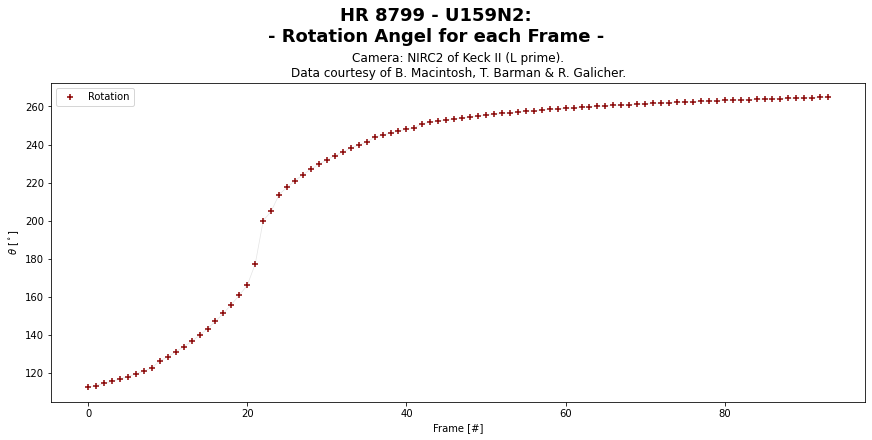

Number of rotaton angles in rotation file ::    94
Number of images                          ::    94
Pixel size of the images                  ::    1224 x 1224


In [2]:
# Q1 answer here

print("Depening on your OS the path might be read as wrong. I unpacked the center_im into the barman_2009_data folder.")
print("In case it complains you need to switch the folder location.")
print("It would make sense to allow the import of the pathlib module to solve these OS differences.")

try:
    rot, rot_head = fits.getdata('barman_2009_data/rotnth.fits', header=True)
    im, head = fits.getdata('barman_2009_data/center_im.fits', header=True)
except Baseexception:
    rot, rot_head = fits.getdata('barman_2009_data\rotnth.fits', header=True)
    im, head = fits.getdata('barman_2009_data\center_im.fits', header=True)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))


x = np.arange(len(rot))

ax.plot(x, rot, c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(x, rot, c="darkred", marker="+", label="Rotation")



ax.set_xlabel(r'Frame [#]')
ax.set_ylabel(r'$\theta$ [$^\circ$]')
# ax.set_ylim(0., None)
# ax.set_yscale('log')
ax.legend()
ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- Rotation Angel for each Frame -', fontsize=18, weight="bold")
plt.show()


# Q1 end of answer

print("Number of rotaton angles in rotation file ::    {}".format(rot.shape[0]))
print("Number of images                          ::    {}".format(im.shape[0]))
print("Pixel size of the images                  ::    {} x {}".format(im.shape[1],im.shape[2]))

## Subtract off the sky background

Bad/missing values are labelled as `NaN` (Not A Number) in `FITS` files and in `numpy`. You must use `np.nanmedian()` and `np.nansum()` and other `np.nan....` functions to calculate median, sum, standard deviation and other functions correctly accounting for the `NaN` values in the data.

For all the `np.sum`, `np.median` functions, you can also specify one or more `axes` to carry out a median or sum over, and you can specify them as an optional argument passed to the function as `axis=(1,3)` to carry out the function over both the 1 and 3 dimesions.

The sky background varies by several thousand counts between frames, but it can be treated as a constant value across each individual frame. Well over half of the pixels in each frame have sky flux in them, so taking a median of each frame is a good approximation for the sky background for that frame.


---
<span style="  font-size:2em; color: SteelBlue;">Question 7.2</span> <span style="  font-size:1em; color: SteelBlue;"> (3 points): </span>

**Calculate the median of each of the frames, and plot it as a function of frame number in the cube. Then subtract off the median value of each individual frame from that frame. This can be done for all the frames in the cube in one go using `numpy` broadcasting, or (far more slowly) using an appropriate `for` loop. Call the result `im_bg`.** 

<div class="alert alert-block alert-info">
<b>Tip: </b> You don't need any <code>for</code> loops to do this! </div>

**Additionally, set all the `NaN` values to zero by using. There is a `numpy` function that can help you with this**

***


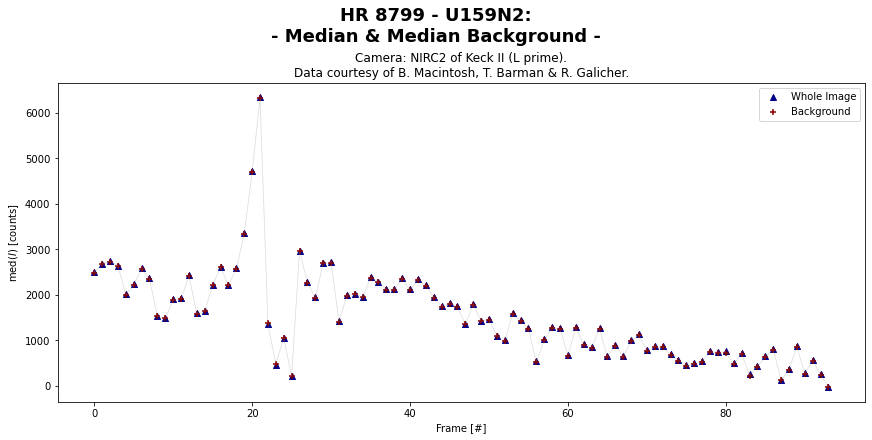

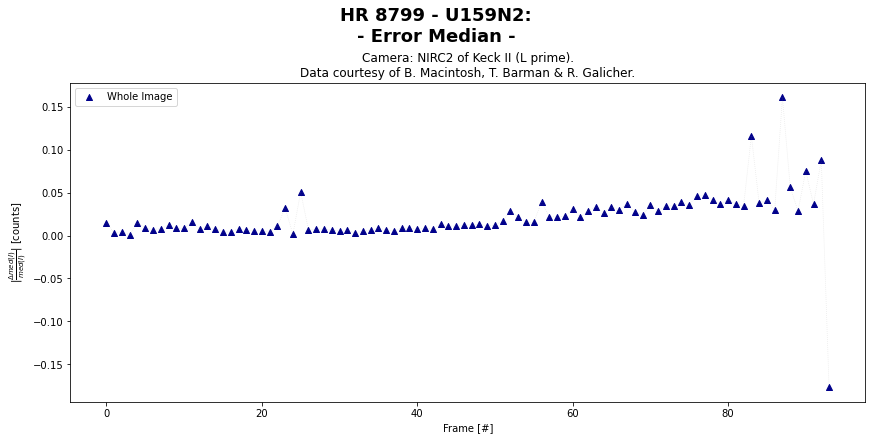

In [3]:
# Q2 answer here

medians_bad = np.array([np.nanmedian(img) for img in im])
medians = np.array([np.nanmedian(img[:500, :500]) for img in im])
means = np.mean(medians)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))


x = np.arange(len(rot))

ax.plot(x, medians_bad, c="gray", ls="dotted", alpha=0.2, lw=0.75)
ax.scatter(x, medians_bad, c="darkblue", marker="^", label="Whole Image")

ax.plot(x, medians, c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(x, medians, c="darkred", marker="+", label="Background")



ax.set_xlabel(r'Frame [#]')
ax.set_ylabel(r'med$(I)$ [counts]')
# ax.set_ylim(0., None)
# ax.set_yscale('log')
ax.legend()
ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- Median & Median Background -', fontsize=18, weight="bold")
plt.show()

medians_bad = np.array([np.nanmedian(img) for img in im])
medians = np.array([np.nanmedian(img[:500, :500]) for img in im])
means = np.mean(medians)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))


x = np.arange(len(rot))

ax.plot(x, np.abs(medians - medians_bad) / medians, c="gray", ls="dotted", alpha=0.2, lw=0.75)
ax.scatter(x, np.abs(medians - medians_bad) / medians, c="darkblue", marker="^", label="Whole Image")



ax.set_xlabel(r'Frame [#]')
ax.set_ylabel(r'|$\frac{\Delta med(I)}{med(I)}$| [counts]')
# ax.set_ylim(0., None)
# ax.set_yscale('log')
ax.legend()
ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- Error Median -', fontsize=18, weight="bold")
plt.show()

im_bg = np.nan_to_num(im - medians.reshape((94, 1, 1)), nan=0.)


# Q2 end of answer

<a id='part2'></a>

## Rotating an image 

Let us look at a way to rotate an image on the sky. We will only use the functions as provided in this notebook. You do not have to import other Python libraries to perform these rotations.

<div class="alert alert-block alert-success">
<b>Example 7.1:</b> Make a small image of shape <code>(20,30)</code> with randomly filled values using <code>np.random.random</code>.
</div>


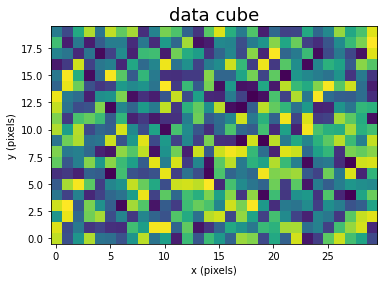

In [4]:
fig, ax = plt.subplots(1,1, figsize=(18,4))   

t1 = np.random.random((20,30))

ax.imshow(t1)
ax.set_xlabel('x (pixels)');  ax.set_ylabel('y (pixels)')  
ax.set_title('data cube', fontsize=18) 

ax.imshow(t1)
plt.show()

<div class="alert alert-block alert-success">
<b>Example 7.1 (continued):</b> Then put this random image into a larger image of shape <code>(50,75)</code> with a rotation of 30 degrees using <code>cen_rot2()</code>. Convince yourself that you understand how the rotation and translation works in <code>cen_rot2()</code> by trying just moving the image to a new place, then rotating it by 30 degrees or -45 degrees, and understand what the output image looks like compared to the input image.
</div>

In [5]:
try:
    %run ../week_1/interactive

    def interactive_rotate_cube(rotate,offx,offy):  
        fig, (ax,ax1,ax2) = plt.subplots(1,3, figsize=(18,4))   
        fig.suptitle("Rotating an image using cen_rot2()",fontsize = 20, y=1.01)
        nx, ny = t1.shape

        ax.imshow(t1)
        ax.set_xlabel('x (pixels)');  ax.set_ylabel('y (pixels)')  
        ax.set_title('data cube', fontsize=16) 

        t_fixed = cen_rot2(t1,0,(50,75), offset1=(offx*nx + 0.5*nx, offy*ny + 0.5*ny))
        ax1.imshow(t_fixed)
        ax1.set_xlabel('x (pixels)');  ax1.set_ylabel('y (pixels)')  
        ax1.set_title("let's put things into perspective", fontsize=16)  

        t2 = cen_rot2(t1,rotate,(50,75), offset1=(offx*nx + 0.5*nx, offy*ny + 0.5*ny))
        ax2.imshow(t2)
        ax2.set_xlabel('x (pixels)');  ax2.set_ylabel('y (pixels)')  
        ax2.set_title('rotated data cube', fontsize=16)  

        plt.show()
        return None

    interactive_plot = interactive(interactive_rotate_cube, 
                                   rotate=widgets.IntSlider(value=30, min=0, max=360, step=5, readout_format='.2f', description="$\\theta_{\\text{rot}} (^{\\circ})$"),
                                   offx=widgets.FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.05, readout_format='.2f', description="offset x"), 
                                   offy=widgets.FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.05, readout_format='.2f', description="offset y") )
    output = interactive_plot.children[-1]
    output.layout.height = '450px'
    interactive_plot
except BaseException:
    # some import issues for me
    pass


<Figure size 432x288 with 0 Axes>

## Derotating the image cube to align with the sky

You can use the function `derot(im, rot, (nx, ny), (sx, sy))` (as defined at the start of the notebook) to produce a cube of images that are `(nx, ny)` in size with the correct derotation to align the sky. 


<div class="alert alert-block alert-success">
<b>Example 7.2:</b> We start off with our larger rotated image from Example 7.1 It had a shape of <code>(50,75)</code> with a rotation of 30 degrees. Now, let us derotate the image back using <code>derot_cube</code> Convince yourself that you understand how the rotation and translation works in <code>derot_cube</code>. 
</div>


In [6]:
def interactive_derotate_cube(derotate):  
    fig, (ax,ax1,ax2) = plt.subplots(1,3, figsize=(18,4))   
    fig.suptitle("(De)rotating an image using derot_cube()",fontsize = 20, y=1.01)
    
    offx = offy = 0.25  ;    nx, ny = t1.shape
    t2 = cen_rot2(t1,30,(50,75), offset1=(offx*nx, offy*ny))
    
    nx, ny = t2.shape
    ax.imshow(t2)
    ax.set_xlabel('x (pixels)');  ax.set_ylabel('y (pixels)')  
    ax.set_title('cen_rot2( data cube )', fontsize=16) 
    
    offx = offy = 0.50 
    t3 = derot_cube(np.asarray([t2]),np.asarray([0]), (50,75), star_cen=(offx*nx, offy*ny))
    nim, nx, ny = t3.shape
    ax1.imshow(t3[0])
    ax1.set_xlabel('x (pixels)');  ax1.set_ylabel('y (pixels)') 
    degreesign = "$^{\\circ}$"
    title = "derot_cube(data cube) with 0"
    ax1.set_title(title+degreesign, fontsize=16) 
    
    t4 = derot_cube(np.asarray([t2]),np.asarray([derotate]),(50,75), star_cen=(offx*nx, offy*ny))
    ax2.imshow(t4[0])
    ax2.set_xlabel('x (pixels)');  ax2.set_ylabel('y (pixels)')  
    title = "derot_cube(data cube) with {}".format(derotate)
    ax2.set_title(title+degreesign, fontsize=16) 

    plt.show()
    return None 

interactive_plot = interactive(interactive_derotate_cube, 
                               derotate=widgets.IntSlider(value=-30, min=-180, max=180, step=5, readout_format='.2f', description="$\\theta_{\\text{rot}} (^{\\circ})$"),
                               )
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot


interactive(children=(IntSlider(value=-30, description='$\\theta_{\\text{rot}} (^{\\circ})$', max=180, min=-18…


---
<span style="  font-size:2em; color: SteelBlue;">Question 7.3</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Determine the centroid of the star `sx, sy` to the nearest pixel in the data cube by visual inspection. Your derotated images should have a dimension of 501 by 501. Plot the first derotated image. Write out the derotated cube to `out.fits` and use `ds9` to confirm that the PSF is rotated in the `out.fits` images and has the correct size. Use `wfits(cube, fname)` to write out the cube.** 

***

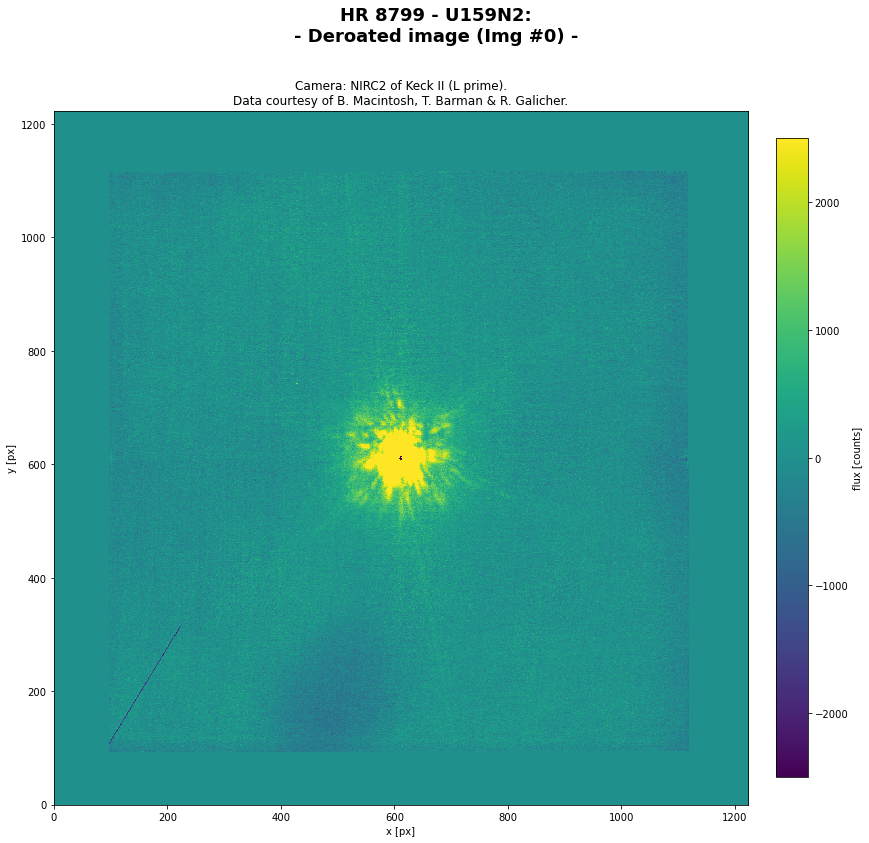

In [7]:
# Q3 answer here

sx, sy = 610, 610
nx, ny = 501, 501

out = derot_cube(im_bg, rot, (nx, ny), (sx, sy))

fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(im_bg[0],
                    vmin=-2500, vmax=2500)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- Deroated image (Img #0) -', fontsize=18, weight="bold")
plt.show()

wfits(out, "out.fits")

# Q3 end of answer

## Subtract off the median from all frames then derotate and median


---
<span style="  font-size:2em; color: SteelBlue;">Question 7.4</span> <span style="  font-size:1em; color: SteelBlue;"> (4 points): </span>

1. **Take the median of `im_bg` to estimate the telescope PSF for the whole dataset. The median [1224 x 1224] will remove any planets that are rotating in the frames. Call this median the `im_bg_med`.**
2.  **Subtract the median image off of all individual images. Call these images `im_bg_medsub`.** 
3.  **Derotate the image cube back to the original orientation to align all the planets in the cube, then take the median of that data cube and write it out to `med_sub.fits`. Examine it with `ds9`.**

**Answer the question: How many planets you can see?** 


<div class="alert alert-block alert-info">
<b>Tip: </b>  <code>im_bg</code> has zeroes for the  <code>NaN</code> values so we can use <code>im_bg</code> safely </div>

***



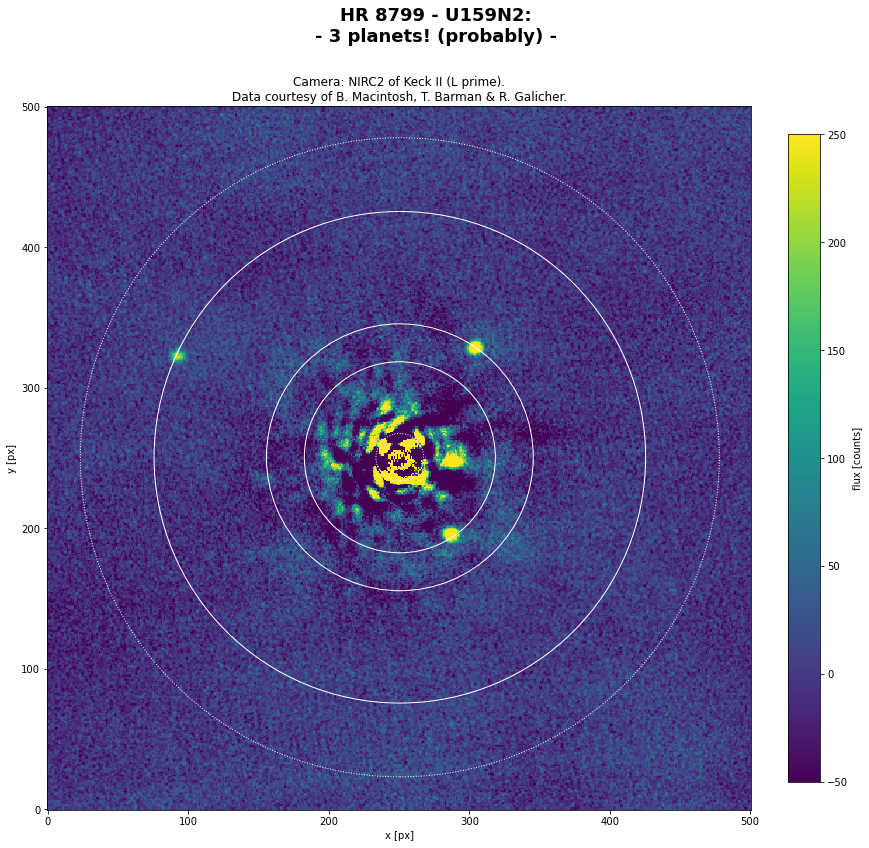

In [8]:
# Q4 answer here

im_bg_med = np.median(im_bg, axis=0)
im_bg_medsub = im_bg - im_bg_med

med_sub = derot_cube(im_bg_medsub, rot, (nx, ny), (sx, sy))
med_sub = np.median(med_sub, axis=0)
wfits(med_sub, "med_sub.fits")

fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(med_sub,
                    vmin=-50, vmax=250)

rad1, rad2, rad3 = 68., 95., 175.

p1 = mpl.patches.Circle((nx / 2., ny / 2.), rad1, fc="none", ec="w", ls="solid")
ax.add_artist(p1)

p2 = mpl.patches.Circle((nx / 2., ny / 2.), rad2, fc="none", ec="w", ls="solid")
ax.add_artist(p2)

p3 = mpl.patches.Circle((nx / 2., ny / 2.), rad3, fc="none", ec="w", ls="solid")
ax.add_artist(p3)

r_adi = rad1 * 0.25
r_ring = np.linspace(r_adi, rad3 * 1.3, 81)
r_ring_mean = np.mean([r_ring[:-1], r_ring[1:]], axis=0)

p4 = mpl.patches.Circle((nx / 2., ny / 2.), r_ring[0], fc="none", ec="w", ls="dotted")
ax.add_artist(p4)

p5 = mpl.patches.Circle((nx / 2., ny / 2.), r_ring[-1], fc="none", ec="w", ls="dotted")
ax.add_artist(p5)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- 3 planets! (probably) -', fontsize=18, weight="bold")
plt.show()

# Q4 end of answer

I see three non-rotating sources. Another potential source is close  to the central star, however it is in a reagion where we have significant noise from speckles remaining. We cannot say if the three clear sources are planets or something else that is stationary in the background (i.e. background stars or even galaxies), since the star was only observed over one night. Naturally, we would suspect that they are planets, especially since we are probing at L prime and, background stars that would be visible in the cube would be very obvious at other wavelengths. Lasty, we would need to be very unlucky to have three stars, all visible like this, at such close separations without seeing them otherwise.

#### Adding a progressbar 

As large routines can take up a long time to compute completely, you might want to consider to make an progressbar. Please do make sure that **you do not import new libraries** as the Jupyter notebook should still be able to **compile cleanly**. Therefore you have to make use of libraries that are always available (at least with installing Python using `Anaconda`). 


In [9]:
import time,sys
# please just let us use tqdm :,(

def ProgressBar(total, progress):
    """ ProgressBar - Displays or updates a console progress bar.
    ######################     EXAMPLE     ######################
    
    runs = 300
    for run_num in range(runs):
        time.sleep(.1)
        ProgressBar(runs, run_num + 1)
        
    #############################################################
    Original source: https://stackoverflow.com/a/15860757/1391441
    """
    barLength, status = 20, ""
    progress = float(progress) / float(total)
    if progress >= 1.:
        progress, status = 1, "\r\n"
    block = int(round(barLength * progress))
    text = "\r[{}] {:.0f}% {}".format(
        "#" * block + "-" * (barLength - block), round(progress * 100, 0),
        status)
    sys.stdout.write(text)
    sys.stdout.flush()

    
## A very easy but effective way to print your time
print("Progress [{0:5d}/{1}] ---  {2:.3f}%")

Progress [{0:5d}/{1}] ---  {2:.3f}%


## Implementing ADI on the Keck data set

Today you will implement ADI using the Marois paper as guidance. 

**You will need to make three nested `for` loops:**

1.  **looping over individual frames**
2.   **looping over different annuli on which to carry out the ADI frame selection**
3.   **looping over different values of `a` (Equation 8 in Marois 2006) to determine the best value to minimise the R.M.S.**



<div class="alert alert-block alert-info">
<b>Tip: </b> Running the entire routine takes about 10 minutes to do on my 9 year old laptop! So when you're writing and debugging this, remember to do it with only 40 or so frames to make sure your code is working before doing the whole cube. </div>



---

<span style="  font-size:2em; color: SteelBlue;">Question 7.5</span> <span style="  font-size:1em; color: SteelBlue;"> (4 points): </span>

**Setting up the DAI routine, according to section 5.2 in Marois 2006** 

1.  **The $I^D_I$ would be the meadian of all images subtracted from the individual images.** *(you already calculated this!)* **Refer to/Call these images as `ID`. Make an output array `IADI` to store ADI result**
*   **You will need:** 
    * **(i) `D` the diameter of the telescope,** 
    * **(ii) `nwid` number of FWHM minimum separation required for the ADI routine,** 
    * **(iii) `wlen` the central wavelength and**
    * **(iv) `pscale` the pixelscale.**
    <br><br>
*   **Use `r_theta` to create an array `r_arcsec` that contains the values of radii away from the center in terms of arcseconds.**
*   **Create 80 annuli for the radii where you might expect to find planets. To do this you have to create an array `r_ring` containing all annuli boarders (80 + 1). The inner and outer boardes of each annulus is then defined between `r_ring`[n] and `r_ring`[n+1]. Call the inner most annulus `r_adi`.**

***


In [10]:
# Q5 answer here
ID = im_bg_medsub[:, 
                  im_bg_medsub.shape[1]//2 - ny//2:im_bg_medsub.shape[1]//2 + ny//2 + 1,
                  im_bg_medsub.shape[2]//2 - nx//2:im_bg_medsub.shape[2]//2 + nx//2 + 1]

IADI = np.zeros_like(ID)

D = 10 * 1e6                # microns
nwid = 1.5                  # FWHMs
wlen = (3.42 + 4.12) / 2.   # microns
pscale = 10 * 0.001         # mas/pixel

r_arcsec, __ = r_theta(ID[0], nx/2, ny/2) 
r_arcsec *= pscale


# Q5 end of answer 

---

<span style="  font-size:2em; color: SteelBlue;">Question 7.6</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>


**Calculate out the minimum angle `min_ang` using inverse trigonometry.**


<div class="alert alert-block alert-info">
<b>Tip: </b> The minimum amgle is the angle that you must turn in order to move .... FWHM, see end of Section 5.2 or Marois et al. (2006).</div>




---

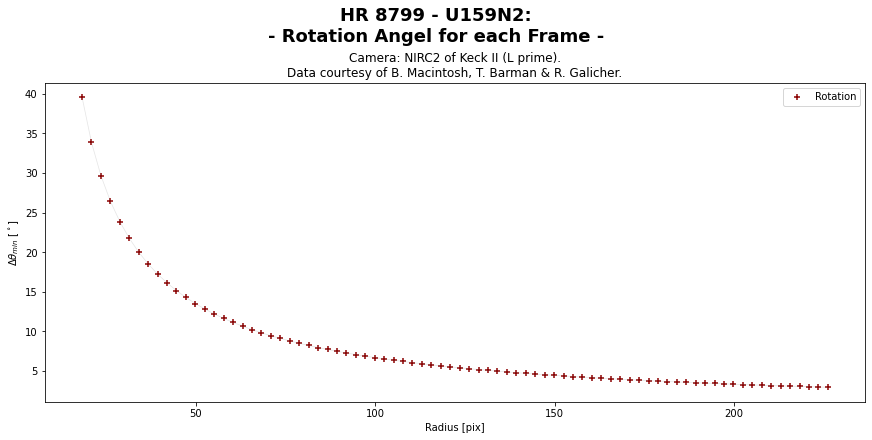

In [11]:
# Q6 answer here

d_min = nwid * (wlen / D) * 206300
min_ang = np.arcsin(d_min / (r_ring_mean * pscale)) * 180./np.pi

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(r_ring_mean, min_ang, c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(r_ring_mean, min_ang, c="darkred", marker="+", label="Rotation")



ax.set_xlabel(r'Radius [pix]')
ax.set_ylabel(r'$\Delta \theta_{min}$ [$^\circ$]')
ax.legend()
ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- Rotation Angel for each Frame -', fontsize=18, weight="bold")
plt.show()

# Q6 end of answer

# ADI loop
In the previous two questions we obtained all the information regarding the observing instrument and the minimum angle that we can use to rotate our frames. Let us now finish our ADI routine. Recall from before that there will be three loops: looping over individual frames, different annuli and different values of `a`. 


---

<span style="  font-size:2em; color: SteelBlue;">Question 7.7</span> <span style="  font-size:1em; color: SteelBlue;"> (6 points): </span>

**Finish the ADI routine, according to Marois et al. (2006)** 

1.  **To set up your test run: Select all annuli for one single individual frame**
*   **For each annulus, calculate the 4 closest frames (in `rot`) in time. Store the median over these images as `refrerence_frames`**

<div class="alert alert-block alert-info">
<b>Tip 1: </b> What is <code>delta_angle</code> from current frame angle? Which frames have angles greater than <code>min_ang?</code> </div>


3.   **Minimise the rms of $\text{frame} - a \times \text{reference_frame}$ by finding the best value for `a`** using a linear least squares fit

<div class="alert alert-block alert-info">
<b>Tip 2: </b> In the paper this is summarised by the equation: $$
I_{i}^{\mathrm{ADI}}=I_{i}^{D}-a \times \operatorname{median}\left(I_{i-b}^{D}, I_{i-b-1}^{D}, I_{i+c}^{D}, I_{i+c+1}^{D}\right)
$$ </div>



4.  **Store the result in your output array `IADI`**
*   **Loop over all annuli in one frame -- test your routine for one frame here!**
*   **Loop over individual frames**
*   ****



***


$$\boldsymbol{I}_i^{ADI} = argmin_a \left[ | \boldsymbol{I}_i^D - a \cdot med( \boldsymbol{R}_{4-NN}) |\right], \quad \{ R \subset \boldsymbol{I} : \Delta \theta_{\boldsymbol{I}} > \theta_{min}(r)\}$$ 

In [12]:
# Q7 answer here
n_frames = len(ID)
n_refs = 4

# ADI loop:

mask = np.array([(r_inner * pscale < r_arcsec) * (r_arcsec < r_ring[i+1] * pscale) for i, r_inner in enumerate(r_ring[:-1])])
a_vals = np.linspace(-0.1, 1.2, 50)


def inner_loop(i):
    frame_rot = rot[i]
    for j, ring in enumerate(mask):
        frames_mask = np.ma.masked_array(np.arange(len(ID)), 
                                         mask=np.abs(rot - frame_rot) < min_ang[j]).mask
        neighbours_mask = np.argwhere(frames_mask)
        
        free_before = np.sum(~frames_mask[:i])
        free_after = np.sum(~frames_mask[i:])
        free_edge = np.clip(np.minimum(free_before, free_after), a_max=2, a_min=None)
        
        free_before = np.minimum(free_before, n_refs - free_edge)
        free_after = np.minimum(free_after, n_refs - free_edge)
        
        mask_start = neighbours_mask[0]
        mask_end = neighbours_mask[-1]
        
        first = np.clip(mask_start - free_before,
                        a_min=0,
                        a_max=im.shape[0]-5)
        last = np.clip(mask_end + free_after + 1,
                       a_min=5,
                       a_max=im.shape[0])
        idxs = np.arange(first, last)
        neighbours_mask = ~np.isin(np.arange(len(ID)), idxs)
        combined_mask = np.logical_or(frames_mask, neighbours_mask)
        
        
        
        idxs = np.ma.masked_array(np.arange(len(ID)),
                                  mask=combined_mask).compressed()
        
        assert len(idxs) == 4, "Must select 4 images"
        
        frame, reference_frame = np.extract(ring, ID[i]), np.extract(ring, np.median(ID[idxs], axis=0))
        

        rms_min = np.argmin([np.mean(np.square(frame - reference_frame * a)) for a in a_vals])
        a = a_vals[rms_min]
        IADI[i][ring] = frame - reference_frame * a
    return IADI[i]

for i in np.arange(len(ID)):
    __ = inner_loop(i)
    ProgressBar(len(ID), i+1)

        
# Q7 end answer

[####################] 100% 


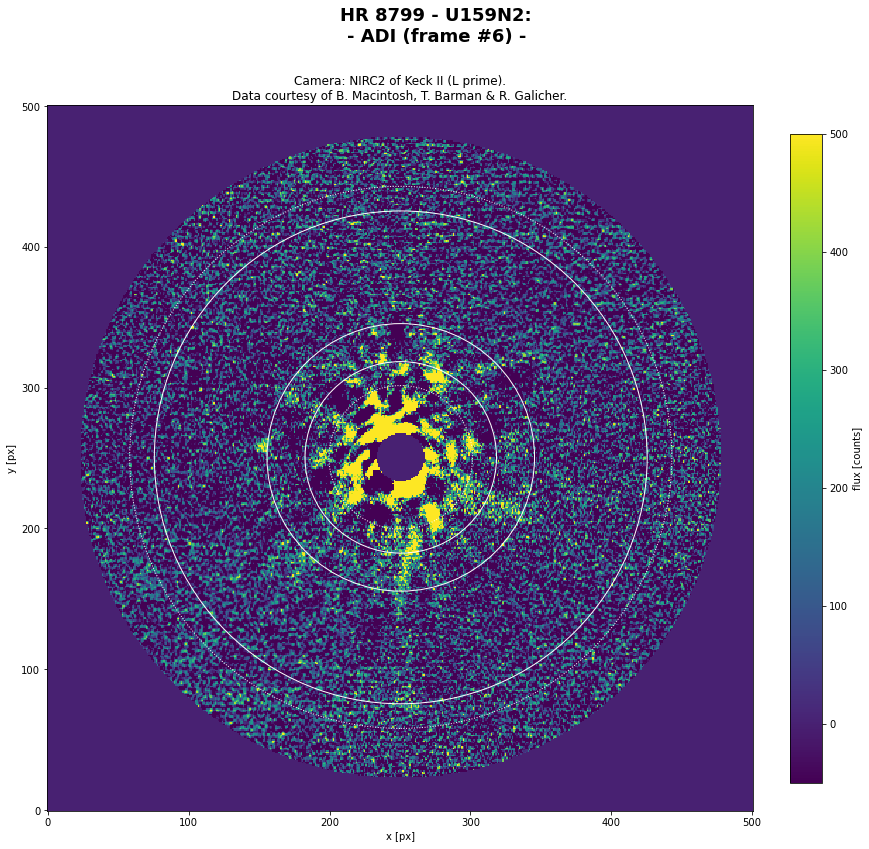

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

this_im = ax.imshow(IADI[5], vmin=-50, vmax=500)

rad1, rad2, rad3 = 68., 95., 175.

p1 = mpl.patches.Circle((nx / 2., ny / 2.), rad1, fc="none", ec="w", ls="solid")
ax.add_artist(p1)

p2 = mpl.patches.Circle((nx / 2., ny / 2.), rad2, fc="none", ec="w", ls="solid")
ax.add_artist(p2)

p3 = mpl.patches.Circle((nx / 2., ny / 2.), rad3, fc="none", ec="w", ls="solid")
ax.add_artist(p3)

r_adi = rad1 * 0.75
r_ring = np.linspace(r_adi, rad3 * 1.1, 81)
r_ring_mean = np.mean([r_ring[:-1], r_ring[1:]], axis=0)

p4 = mpl.patches.Circle((nx / 2., ny / 2.), r_ring[0], fc="none", ec="w", ls="dotted")
ax.add_artist(p4)

p5 = mpl.patches.Circle((nx / 2., ny / 2.), r_ring[-1], fc="none", ec="w", ls="dotted")
ax.add_artist(p5)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- ADI (frame #6) -', fontsize=18, weight="bold")
plt.show()

## Writing out the ADI image


---

<span style="  font-size:2em; color: SteelBlue;">Question 7.8</span> <span style="  font-size:1em; color: SteelBlue;"> (2 points): </span>

**Derotate the ADI image cube to the sky coordinates and median it together, and write it out to `ADI.fits`**

***

In [14]:
# Q8 answer here

IADI_derot = derot_cube(IADI, rot, (501, 501), (250, 250))
IADI_derot = np.median(IADI_derot, axis=0)
wfits(IADI_derot, "ADI.fits")

# Q8 end answer

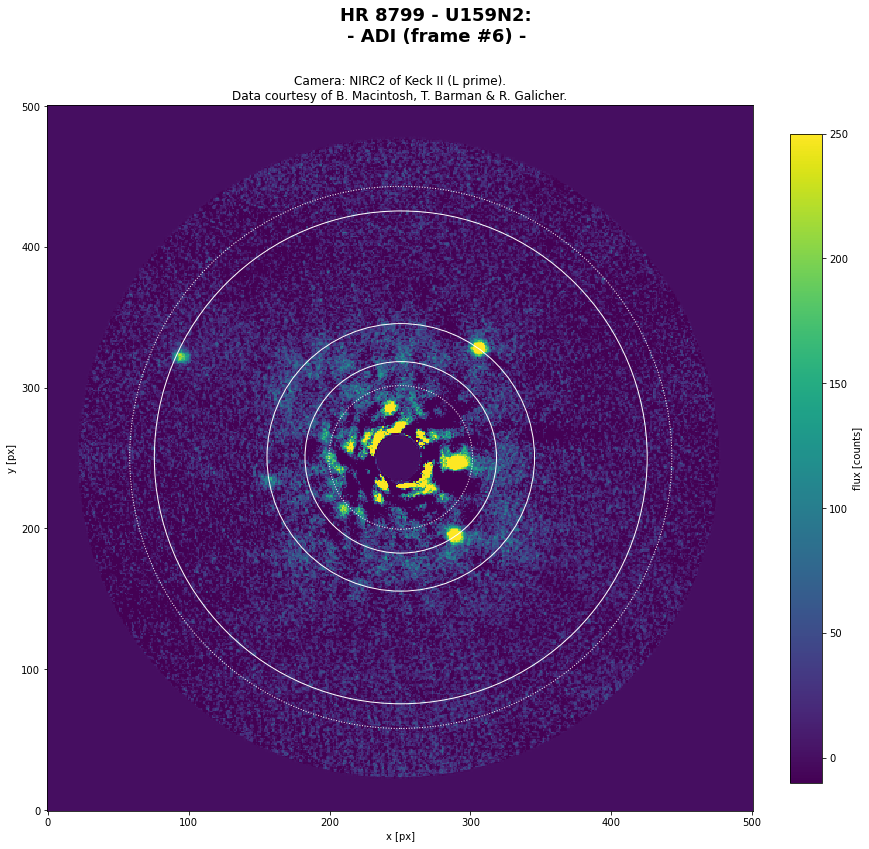

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

this_im = ax.imshow(IADI_derot, vmin=-10, vmax=250)

p1 = mpl.patches.Circle((nx / 2., ny / 2.), rad1, fc="none", ec="w", ls="solid")
ax.add_artist(p1)

p2 = mpl.patches.Circle((nx / 2., ny / 2.), rad2, fc="none", ec="w", ls="solid")
ax.add_artist(p2)

p3 = mpl.patches.Circle((nx / 2., ny / 2.), rad3, fc="none", ec="w", ls="solid")
ax.add_artist(p3)

p4 = mpl.patches.Circle((nx / 2., ny / 2.), r_ring[0], fc="none", ec="w", ls="dotted")
ax.add_artist(p4)

p5 = mpl.patches.Circle((nx / 2., ny / 2.), r_ring[-1], fc="none", ec="w", ls="dotted")
ax.add_artist(p5)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- ADI (frame #6) -', fontsize=18, weight="bold")
plt.show()

## Comparing simple median and ADI


---

<span style="  font-size:2em; color: SteelBlue;">Question 7.9</span> <span style="  font-size:1em; color: SteelBlue;"> (4 points): </span>

**Define annuli from 0.2 arcsec through to 4 arcsec in 0.1 arcsec steps. Plot the radius of the middle of width of the ring versus the r.m.s. in each ring, for first the simple median subtracted case, and for the ADI subtracted case. In this way, we can compare the noise at different radii for both the simple median case and the ADI case.** 

**Answer the question: At what radii does ADI work the best, and by how much of a factor?**

***


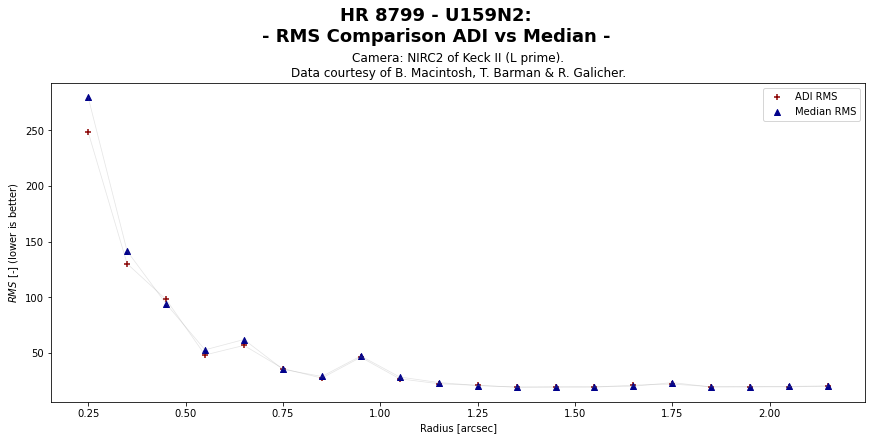

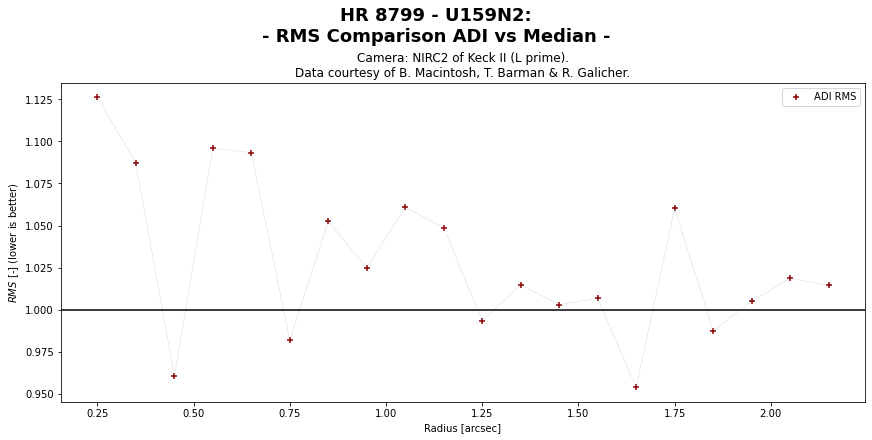

In [16]:
# Q9 answer here

annuli = np.arange(0.2, 2.3, 0.1)
as_scale = 10 * 1000 # arcsec / px
a_mask = np.array([(r_inner < r_arcsec) * (r_arcsec < annuli[i+1]) for i, r_inner in enumerate(annuli[:-1])])

middle_ring = np.mean([annuli[:-1], annuli[1:]], axis=0)

rms_adi = np.array([np.std(np.extract(ring, IADI_derot)) for ring in a_mask])
rms_median = np.array([np.std(np.extract(ring, med_sub)) for ring in a_mask])


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(middle_ring, rms_adi, c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(middle_ring, rms_adi, c="darkred", marker="+", label="ADI RMS")

ax.plot(middle_ring, rms_median, c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(middle_ring, rms_median, c="darkblue", marker="^", label="Median RMS")

ax.set_xlabel(r'Radius [arcsec]')
ax.set_ylabel(r'$RMS$ [-] (lower is better)')
ax.legend()
ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- RMS Comparison ADI vs Median -', fontsize=18, weight="bold")
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(middle_ring, rms_median / rms_adi, c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(middle_ring, rms_median / rms_adi, c="darkred", marker="+", label="ADI RMS")

ax.axhline(1., c="k")

ax.set_xlabel(r'Radius [arcsec]')
ax.set_ylabel(r'$RMS$ [-] (lower is better)')
ax.legend()
ax.set_title('Camera: NIRC2 of Keck II (L prime).\nData courtesy of B. Macintosh, T. Barman & R. Galicher.') 
fig.suptitle('HR 8799 - U159N2:\n- RMS Comparison ADI vs Median -', fontsize=18, weight="bold")
plt.show()

# Q9 end answer

Generally works better at smaller separations as we expect since we are trying to remove the specles caused by the instrument and the ADI allows us to better estimate what "flux" is due to speckles. At small separations ADI is roughly 5-10% better. I didnt plot even larger separations mainly to keep runtime down and since we know that the performance is very similar far away from the source.


<div class="alert alert-block alert-info">
<b>REMEMBER:</b> to make sure your code compiles cleanly before submitting it! DO NOT SEND YOUR FITS CUBES BACK! ONLY THIS JUPYTER NOTEBOOK!</div>


---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


In [17]:
# Number of hours taken for this practicum:
# 4-5
# really cool but I sadly didnt have as much time this week